# Lecture 9 - Multiple Testing

Based on [`ISLRv2`](https://web.stanford.edu/~hastie/ISLRv2_website.pdf) Chapter 13.

## Recall: (may be asked in the oral exams)


1. In hypothesis testing, $\alpha$ refers to the probability that we reject $H_0$, given that $H_0$ is true (Type 1 error).


2. It is also something that we usually select in advance and has a corresponding trade-off with *power* $1-\beta$.


3. Power is the probability that we reject $H_0$, given that $H_0$ is false.


4. We reject our null hypothesis $H_0$ if the p-value is less than our choice of $\alpha$.


---

## The Problem with Multiple Testing

Suppose we flip $1,024$ fair coins ten times each (that's $2^{10} \times 10$ flips). 

Further suppose that we do not know if the coins are fair, so we would like to test the null hypothesis that each of the coins are fair.

There's a $1/1024$ chance that any single coin will come up all tails. That means we would expect one coin to come up all tails, on average.

In [7]:
import numpy as np

np.random.seed(1)

x = np.random.binomial(n=10, p=0.5, size=1024)

print(x)
np.where(x == 0)

[5 6 0 ... 5 5 7]


(array([  2, 250], dtype=int64),)

In [8]:
x = 0 # all Tails from cell above^

# is this coin fair?
# null hypothesis H_0: p = 0.5
# p-value - probability of observing events as extreme as our data, UNDER THE ASSUMPTION that the null hypothesis is true

# p value in this case is probability of all tails and probability of all heads after 10 flips.
p_all_tail = 0.5**10
p_all_head = 0.5**10

p_value = p_all_tail + p_all_head # (1/512)
p_value

0.001953125

Notice that if we analyzed each coin independent of each other, then we would be tempted to (incorrectly) conclude that two of the above coins were not fair. 

In this case, we would have committed two Type 1 errors!

This is the main challenge of *multiple testing*: when testing a large number of null hypothesis, we are bound to get some very small p-values by chance.

If we make a decision about whether to reject each null hypothesis without accounting for the fact that we have performed a very large number of tests, then we may end up reject a great number of true null hypothesis - i.e., making a large number of Type 1 errors.

In summary, rejecting a null hypothesis if the p-value is below $\alpha$ controls the probabilty of falsely rejecting that $H_0$. However, if we do this for $m$ null hypotheses, then the chance of falsely rejecting *at least one of them* is higher.

---

## The Family-Wise Error Rate

The **family-wise error rate** (FWER) is the probability of making *at least one* Type 1 error. 

Under the (very strong) assumption that the $m$ tests are independent and that all $m$ null hypotheses are true, then

$$\text{FWER}(\alpha) = 1 - (1-\alpha)^{m}$$

The methods described below are said to *control* for this error rate.

In [9]:
alpha = 0.05

1-(1-alpha)**1024

1.0

---

## The Bonferroni Method

The **Bonferroni method**, or **Bonferroni correction**, sets the threshold for rejecting each hypothesis test to $\frac{\alpha}{m}$ (i.e. reject if $\text{p-value} < \frac{\alpha}{m}$).

#### Example - Analyzing Hedge Fund Manager Returns

The `Fund` dataset records the monthly percentage excess (i.e. in excess of the market) returns for 2,000 fund managers over 50 months.

In [10]:
import numpy as np
import pandas as pd

df = pd.read_csv('Fund.csv') # Returns of 2,000 hedge fund managers over 50 months
df = df.iloc[:, :5]
df.describe().round(2)

,Manager1,Manager2,Manager3,Manager4,Manager5
count,50.00,50.00,50.00,50.00,50.00
mean,3.00,-0.10,2.80,0.50,0.30
std,7.42,6.86,7.55,6.71,6.78
min,-13.55,-12.04,-13.34,-13.80,-13.05
25%,-1.37,-4.62,-3.41,-4.97,-4.32
50%,2.30,-1.39,4.21,0.48,-0.11
75%,7.66,5.79,8.27,5.97,3.42
max,16.27,12.53,17.01,16.37,17.16


By just eyeballing it, manager 1 seems to perform better with mean 3.0. Is this manager really good at analyzing the market? or is he just lucky. Similarly, is manager 2 really bad? or just really unlucky. We can do a more formal test.

Let's calculate the t-statistics and p-values under the null hypothesis $H_{0j}: \mu_j = 0$. where j = manager<br> 
Note:
If $\mu_j =0$ you are as good as the market

In [11]:
from scipy.stats import t

df_stat = pd.DataFrame()
df_stat['mean'] = df.mean()
df_stat['stdev'] = df.std()
df_stat['t_stat'] = ((df.mean() - 0)/df.std())*np.sqrt(df.shape[0])  # tstat = (mean - null hypo) / (std/sqrt of n)
df_stat['p_value'] = (1 - t.cdf(df_stat['t_stat'].abs(), df.shape[0]-1))*2 # degrees of freedom = 50 -1 = 49

df_stat

,mean,stdev,t_stat,p_value
Manager1,3.0,7.416198,2.860388,0.006202
Manager2,-0.1,6.855655,-0.103142,0.918271
Manager3,2.8,7.549834,2.622440,0.011601
Manager4,0.5,6.708204,0.527046,0.600540
Manager5,0.3,6.782330,0.312772,0.755782


for manager 1, `tstat = 2.86`, calculating the pvalue is shown below. `t.cdf(tstat_1)` is the blue area

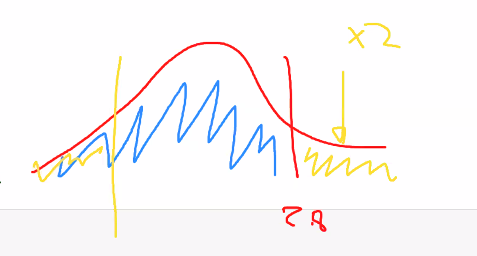

Suppose we wish to control the Type 1 error at level $\alpha = 0.05$ for each fund manager separately. Using the Bonferroni correction, our rejection threshold becomes

$$\frac{\alpha}{m} = \frac{0.05}{5} = 0.01$$

We then conclude that `Manager1` has significantly non-zero excess retrurns. We reject $H_{01}: \mu_1 = 0$, and cannot reject the rest.

The Bonferroni correction gives us "peace of mind" that we have not false rejected too many null hypotheses, but for a price: we will make quite a few Type 2 errors.

This method is by far the best-known and most commonly used multiplicity correction in all of statistics.

---

## Holm's Step-Down Procedure

**Holm's Step-Down Procedure**, or **Holm's method**, similarly controls FWER but is less conservative than Bonferroni (and hence has greater power).

The algorithm is as follows:

1. Specify $\alpha$ to control FWER


2. Compute p-values


3. Order the p-values so that $p_{(1)} \leq p_{(2)} \leq \cdots \leq p_{(m)}$


4. Define

$$L = \min \Big\{ j : p_{(j)} > \frac{\alpha}{m + 1 - j} \Big\}$$


5. Reject all null hypothesis $H_{0j}$ for which $p_{(j)} < p_{(L)}$

In [12]:
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True)
df_stat['L_thresholds'] = alpha/(df.shape[1] + 1 - (np.arange(5) + 1)) 
df_stat

,mean,stdev,t_stat,p_value,L_thresholds
Manager1,3.0,7.416198,2.860388,0.006202,0.010000
Manager3,2.8,7.549834,2.622440,0.011601,0.012500
Manager4,0.5,6.708204,0.527046,0.600540,0.016667
Manager5,0.3,6.782330,0.312772,0.755782,0.025000
Manager2,-0.1,6.855655,-0.103142,0.918271,0.050000


In the example above, $L = 3$. Thus we reject all null hypotheses before that and conclude that `Manager1` and `Manager3` has significantly non-zero excess retrurns.

Here we see that Holm's method is more powerful compared to Bonferroni.

---

## Final Notes on Bonferroni vs Holm

Bonferroni's method and Holm's method can be used in virtually any setting. They make no assumptions about the nature of the null hypotheses, the type of test statistic, or the (in)dependence of the p-values. (non parametric)

However, in certain very specific settings, we can achieve higher power by using more specialized methods like `Tukey's method` and `Scheffe's method`, see ISLRv2.

Finally, we can perform both methods automatically using [`statsmodels.stats.multitest.multipletests`](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html)!

In [5]:
from statsmodels.stats.multitest import multipletests

multipletests(df_stat['p_value'], alpha=0.05, method='bonferroni', is_sorted=True)

(array([ True, False, False, False, False]),
 array([0.03101178, 0.05800491, 1.        , 1.        , 1.        ]),
 0.010206218313011495,
 0.01)

In [15]:
from statsmodels.stats.multitest import multipletests
multipletests(df_stat['p_value'], alpha=0.05, method='bonferroni', is_sorted=True)

(array([ True, False, False, False, False]),
 array([0.03101178, 0.05800491, 1.        , 1.        , 1.        ]),
 0.010206218313011495,
 0.01)

In [16]:
multipletests(df_stat['p_value'], alpha=0.05, method='holm', is_sorted=True)

(array([ True,  True, False, False, False]),
 array([0.03101178, 0.04640393, 1.        , 1.        , 1.        ]),
 0.010206218313011495,
 0.01)

---

## The False Discovery Rate

When $m$ is large, then trying to prevent *any* false positives (as in controling FWER) is too stringent. 

Instead, we might try to make sure that the ratio of false positives $\text{FP}$ to total positives $\text{FP} + \text{TP} = \text{PP}$ is sufficiently low, so that *most* of the reject null hypotheses are not false positives.

The expected value of this ratio

$$E\left[\frac{\text{FP}}{\text{FP} + \text{TP}} \right] = E\left[\frac{\text{FP}}{\text{PP}}\right]$$

is called the **false discovery rate** (FDR).

When we control FDR at say level $q = 20\%$, we are rejecting as many null hypotheses as possible while guaranteeing that no more than $20\%$ of those rejected nulls are false positives, *on average*.

---

## The Benjamini-Hochberg Procedure

One method for controlling FDR is called the **Benjamini-Hochberg Procedure**. 

The algorithm is as follows:

1. Specify $q$ to control FDR


2. Compute p-values


3. Order the p-values so that $p_{(1)} \leq p_{(2)} \leq \cdots \leq p_{(m)}$


4. Define

$$L = \max \Big\{ j : p_{(j)} < \frac{qj}{m} \Big\}$$


5. Reject all null hypothesis $H_{0j}$ for which $p_{(j)} \leq p_{(L)}$

Using this method guarantees that FDR $\leq q$. 

Also, this holds regardless of how many null hypotheses are true, and regardless of the distribution of the p-values for the null hypothesis that are false.

In [13]:
df_stat = pd.DataFrame()
df_stat['mean'] = df.mean()
df_stat['stdev'] = df.std()
df_stat['t_stat'] = (df.mean()/df.std())*np.sqrt(df.shape[0])
df_stat['p_value'] = (1 - t.cdf(df_stat['t_stat'].abs(), df.shape[0]-1))*2
df_stat.sort_values(by='p_value', inplace=True)

df_stat

,mean,stdev,t_stat,p_value
Manager1,3.0,7.416198,2.860388,0.006202
Manager3,2.8,7.549834,2.622440,0.011601
Manager4,0.5,6.708204,0.527046,0.600540
Manager5,0.3,6.782330,0.312772,0.755782
Manager2,-0.1,6.855655,-0.103142,0.918271


In [17]:
df_stat = pd.DataFrame()
df_stat['mean'] = df.mean()
df_stat['stdev'] = df.std()
df_stat['t_stat'] = (df.mean()/df.std())*np.sqrt(df.shape[0])
df_stat['p_value'] = (1 - t.cdf(df_stat['t_stat'].abs(), df.shape[0]-1))*2
df_stat.sort_values(by='p_value', inplace=True)

df_stat

,mean,stdev,t_stat,p_value
Manager1,3.0,7.416198,2.860388,0.006202
Manager3,2.8,7.549834,2.622440,0.011601
Manager4,0.5,6.708204,0.527046,0.600540
Manager5,0.3,6.782330,0.312772,0.755782
Manager2,-0.1,6.855655,-0.103142,0.918271


In [18]:
q = 0.2

df_stat['L_thresholds'] = q*(np.arange(5) + 1)/df.shape[1]
df_stat

,mean,stdev,t_stat,p_value,L_thresholds
Manager1,3.0,7.416198,2.860388,0.006202,0.04
Manager3,2.8,7.549834,2.622440,0.011601,0.08
Manager4,0.5,6.708204,0.527046,0.600540,0.12
Manager5,0.3,6.782330,0.312772,0.755782,0.16
Manager2,-0.1,6.855655,-0.103142,0.918271,0.20


In [19]:
from statsmodels.stats.multitest import multipletests

multipletests(df_stat['p_value'], alpha=q, method='fdr_bh', is_sorted=True)

(array([ True,  True, False, False, False]),
 array([0.02900246, 0.02900246, 0.91827115, 0.91827115, 0.91827115]),
 0.043647500209963,
 0.04)

---

### The Full Dataset

In [73]:
df_f = pd.read_csv('Fund.csv')
df_f.describe().round(2)

,Manager1,Manager2,Manager3,Manager4,Manager5,Manager6,Manager7,Manager8,Manager9,Manager10,...,Manager1991,Manager1992,Manager1993,Manager1994,Manager1995,Manager1996,Manager1997,Manager1998,Manager1999,Manager2000
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,...,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,3.00,-0.10,2.80,0.50,0.30,4.03,-3.89,-3.20,1.62,3.74,...,1.23,-0.33,0.71,0.09,-0.07,-0.03,0.91,0.37,-0.39,0.20
std,7.42,6.86,7.55,6.71,6.78,8.12,9.28,6.67,3.61,8.40,...,9.06,4.97,7.71,2.66,3.46,1.50,7.94,1.10,3.69,5.02
min,-13.55,-12.04,-13.34,-13.80,-13.05,-18.12,-30.00,-17.98,-7.17,-16.65,...,-14.12,-11.52,-12.63,-5.49,-10.27,-3.47,-20.12,-1.98,-8.55,-11.41
25%,-1.37,-4.62,-3.41,-4.97,-4.32,0.53,-10.48,-7.96,-1.21,-3.06,...,-4.55,-2.70,-5.30,-2.13,-2.23,-1.23,-3.65,-0.43,-2.72,-3.71
50%,2.30,-1.39,4.21,0.48,-0.11,3.13,-2.73,-4.41,1.97,3.90,...,-0.59,-0.56,0.69,0.17,0.17,0.18,-0.18,0.25,-0.37,1.10
75%,7.66,5.79,8.27,5.97,3.42,9.50,3.03,2.35,4.15,8.31,...,7.55,3.00,5.87,2.13,2.13,0.85,6.21,1.26,1.51,3.64
max,16.27,12.53,17.01,16.37,17.16,19.25,15.09,11.19,7.81,22.69,...,25.00,10.69,19.77,4.59,7.03,2.85,19.35,2.49,10.51,10.42


In [74]:
df = df_f[df_f.mean()[df_f.mean() > 0].index]
df.describe()

,Manager1,Manager3,Manager4,Manager5,Manager6,Manager9,Manager10,Manager12,Manager13,Manager14,...,Manager1987,Manager1988,Manager1989,Manager1990,Manager1991,Manager1993,Manager1994,Manager1997,Manager1998,Manager2000
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,3.000000,2.800000,0.500000,0.300000,4.034479,1.618893,3.740106,2.385129,1.791732,3.981709,...,0.695222,0.682028,1.556912,0.071445,1.234259,0.707515,0.092912,0.911164,0.366860,0.196968
std,7.416198,7.549834,6.708204,6.782330,8.121927,3.607509,8.400806,4.733738,3.765852,9.413686,...,4.757982,9.621276,9.456611,5.552450,9.055526,7.714913,2.662394,7.943628,1.101723,5.017458
min,-13.548972,-13.342552,-13.796156,-13.054242,-18.121510,-7.166604,-16.652256,-6.779443,-5.588026,-11.889837,...,-11.121702,-19.506666,-23.848918,-10.640062,-14.122046,-12.631190,-5.488721,-20.119865,-1.977991,-11.407383
25%,-1.368724,-3.408768,-4.968537,-4.323646,0.531786,-1.208462,-3.059452,-0.461172,-1.147011,-2.497763,...,-2.158902,-5.765851,-2.830012,-3.831994,-4.553318,-5.297593,-2.128047,-3.649233,-0.434230,-3.712282
50%,2.298907,4.210533,0.478584,-0.107457,3.129916,1.966181,3.900450,1.998050,1.606237,1.574431,...,1.529622,1.598009,0.870209,-0.235836,-0.585345,0.694856,0.168904,-0.181650,0.249682,1.099798
75%,7.659399,8.273102,5.966888,3.421845,9.496908,4.151087,8.314393,6.109825,5.058885,8.782191,...,3.788857,7.500096,7.803042,4.140826,7.549238,5.868618,2.130024,6.214012,1.264606,3.639970
max,16.272040,17.006044,16.371866,17.159553,19.246190,7.814687,22.694019,14.038151,10.470247,26.883916,...,12.085733,18.184821,20.528671,11.096786,24.995252,19.773675,4.594854,19.345970,2.488612,10.418316


In [76]:
df_stat = pd.DataFrame()
df_stat['mean'] = df.mean()
df_stat['stdev'] = df.std()
df_stat['t_stat'] = (df.mean()/df.std())*np.sqrt(df.shape[0])
df_stat['p_value'] = (1 - t.cdf(df_stat['t_stat'].abs(), df.shape[0]-1))*2
df_stat.sort_values(by='p_value', inplace=True)

df_stat

,mean,stdev,t_stat,p_value
Manager76,1.403024,2.458689,4.035026,0.000191
Manager508,0.590563,1.093087,3.820290,0.000376
Manager90,4.045128,7.739538,3.695747,0.000553
Manager60,4.570837,8.845411,3.653952,0.000628
Manager195,4.873134,9.509607,3.623521,0.000690
...,...,...,...,...
Manager239,0.010066,9.890011,0.007197,0.994287
Manager1482,0.001569,1.881063,0.005898,0.995318
Manager1911,0.001717,2.201426,0.005514,0.995623
Manager1541,0.002163,8.208870,0.001863,0.998521


In [77]:
multipletests(df_stat['p_value'], alpha=0.1, method='fdr_bh', is_sorted=True)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [79]:
df_stat[:100]

,mean,stdev,t_stat,p_value
Manager76,1.403024,2.458689,4.035026,0.000191
Manager508,0.590563,1.093087,3.820290,0.000376
Manager90,4.045128,7.739538,3.695747,0.000553
Manager60,4.570837,8.845411,3.653952,0.000628
Manager195,4.873134,9.509607,3.623521,0.000690
...,...,...,...,...
Manager139,3.100865,8.431958,2.600396,0.012274
Manager940,2.765586,7.551864,2.589513,0.012620
Manager124,1.974922,5.420186,2.576444,0.013047
Manager192,3.267331,8.986574,2.570893,0.013232
